In [47]:
from langgraph.graph import StateGraph, START,END
from typing import TypedDict,Annotated, Literal
from pydantic import BaseModel,Field
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

True

In [48]:
model=ChatOpenAI(model='gpt-4o-mini')


In [60]:
review="""
I bought this phone from Amazon about two weeks ago and so far I am quite satisfied with the purchase. The phone was delivered on time and the packaging was intact. Setup was easy and the phone feels smooth for daily use like calls, WhatsApp, YouTube, and browsing. The display is bright and clear enough for indoor and outdoor use. Camera quality is good in daylight, though night photos are just average. Battery easily lasts a full day with moderate usage. Overall, for the price I paid, this phone offers good value and I would recommend it to anyone looking for a reliable device for everyday use.
"""

In [50]:
class Sent(BaseModel):
    sentiment:Annotated[Literal['pos','neg'],Field(description="Give sentiment of review")]

In [51]:
class Sentiment(TypedDict):
    review:str
    sentiment:Sent
    reply:str


In [52]:
def find_sentiment(state:Sentiment):
    prompt=f"Based on the review give sentiment "
    sent_model=model.with_structured_output(Sent)
    result=sent_model.invoke(prompt)

    return {
        'sentiment':result.sentiment
    }


In [53]:
def send_reply(state:Sentiment):
    prompt=f"Based review={review} and its sentiment={state['sentiment']} Write a reply to user"

    reply=model.invoke(prompt).content

    return {
        'reply':reply
    }

In [54]:
def get_analysis(state:Sentiment):
    class Analysis(BaseModel):
        issue:Annotated[str,Field(description="Explain issue in less than 50 words")]
        tone:Annotated[Literal['angry','sad','normal','frustated'],Field(description="Tone of review")]
        urgency:Annotated[Literal['urgent','normal','not_urgent'],Field(description="Level of urgency")]

    my_model=model.with_structured_output(Analysis)
    prompt=f"Give Analysis of review :{review}"

    result=my_model.invoke(prompt)

    send_reply(result)

    prompt=f"Base on analysis of Review  \n Analysis: 1.issue: {result.issue} 2.tone:{result.tone} 3.urgency: {result.urgency}\n Write a reply to user"

    reply=model.invoke(prompt).content

    return {
        'reply':reply
    }



In [55]:
def check_condition(state:Sentiment)->Literal['get_analysis','send_reply']:
    if state['sentiment']=='pos':
        return 'send_reply'
    else:
        'get_analysis'


In [56]:
graph=StateGraph(Sentiment)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('get_analysis',get_analysis)
graph.add_node('send_reply',send_reply)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_condition)
graph.add_edge('get_analysis',END)
graph.add_edge('send_reply',END)

workflow=graph.compile()

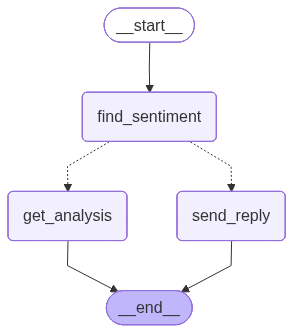

In [57]:
workflow

In [61]:
initial_state={
    'review':review
}

final_state=workflow.invoke(initial_state)

In [62]:
final_state

{'review': '\nI bought this phone from Amazon about two weeks ago and so far I am quite satisfied with the purchase. The phone was delivered on time and the packaging was intact. Setup was easy and the phone feels smooth for daily use like calls, WhatsApp, YouTube, and browsing. The display is bright and clear enough for indoor and outdoor use. Camera quality is good in daylight, though night photos are just average. Battery easily lasts a full day with moderate usage. Overall, for the price I paid, this phone offers good value and I would recommend it to anyone looking for a reliable device for everyday use.\n',
 'sentiment': 'pos',
 'reply': "Hi there!\n\nThank you so much for sharing your experience with your new phone! We're thrilled to hear that you're satisfied with your purchase and that it meets your daily needs. It's great that you found the setup easy and are enjoying the bright display as well as the battery life. Your feedback on the camera performance is also valuable; it’